##### This is built on Kerstin_DSGroup_Summer2020_v2 by Kerstin Wolf on 07/03/2020

<a href="#sec1">1. Data Viz (Kerstin) </a>

<a href="#sec2">2. Train-Test Splitting + Logistic Regression (Vel) </a>

<a href="#sec3">3. XGBoost tryout (Vel) </a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import bqplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

D:\Anaconda\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
#!pip install learntools

In [3]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [4]:
# Set up code checking
#from learntools.core import binder
#binder.bind(globals())
#from learntools.data_viz_to_coder.ex7 import *
#print("Setup Complete")

In [5]:
order_products_train_df = pd.read_csv("order_products__train.csv")
order_products_prior_df = pd.read_csv("order_products__prior.csv")
orders_df = pd.read_csv("orders.csv")
products_df = pd.read_csv("products.csv")
aisles_df = pd.read_csv("aisles.csv")
departments_df = pd.read_csv("departments.csv")
print("Setup Complete")

Setup Complete


In [6]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [7]:
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [9]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [10]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [11]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [12]:
# merging csv files
# what day of the week is 1 in order_dow? Sunday or Monday?
# reordered appears to work in binary 1s and 0s. 1 means yes?
# add_to_cart_order refers to the order in which the product was added to the cart.
# the amount of each product added to each order/cart is not provided.

order_products_prior_df = pd.merge(order_products_prior_df, products_df, on='product_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, orders_df, on='order_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, aisles_df, on='aisle_id', how='left')
order_products_prior_df = pd.merge(order_products_prior_df, departments_df, on='department_id', how='left')
order_products_prior_df.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0,baking ingredients,pantry


In [13]:
order_products_prior_df['product_id'] == 33120

0            True
1           False
2           False
3           False
4           False
            ...  
32434484    False
32434485    False
32434486    False
32434487    False
32434488    False
Name: product_id, Length: 32434489, dtype: bool

In [14]:
# sorts out product with the product id of 33120
# loc gets rows with particular labels in it
egg_whites_order_info = order_products_prior_df.loc[order_products_prior_df['product_id'] == 33120, :]

In [15]:
# All egg whites purchased on a Sunday or Monday (what the first day of the week is).
    # While not super useful now, it might be something to keep in mind. Also, this is currently not sorted in any way.
# Data not given: is the week beginning on Sunday or Monday for order_dow? 
# Interesting idea: making a chart that sorts orders by order_dow.
egg_whites_order_info.loc[egg_whites_order_info['order_dow'] == 1, :]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
6635,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs,dairy eggs
8678,901,33120,3,1,Organic Egg Whites,86,16,160657,prior,31,1,23,8.0,eggs,dairy eggs
17976,1887,33120,6,1,Organic Egg Whites,86,16,25085,prior,78,1,10,3.0,eggs,dairy eggs
25416,2652,33120,1,1,Organic Egg Whites,86,16,37557,prior,15,1,14,21.0,eggs,dairy eggs
28266,2929,33120,1,0,Organic Egg Whites,86,16,173056,prior,4,1,10,21.0,eggs,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32363828,3413704,33120,7,0,Organic Egg Whites,86,16,45486,prior,1,1,18,NaN,eggs,dairy eggs
32406133,3418121,33120,3,1,Organic Egg Whites,86,16,71506,prior,12,1,11,6.0,eggs,dairy eggs
32413994,3418959,33120,4,1,Organic Egg Whites,86,16,4181,prior,6,1,14,30.0,eggs,dairy eggs
32427659,3420373,33120,11,0,Organic Egg Whites,86,16,103838,prior,5,1,16,9.0,eggs,dairy eggs


In [16]:
# orders the egg whites orders by ascending value of user id (user id 155 likes the egg whites)
sorted_egg_whites = egg_whites_order_info.sort_values('user_id', ascending = True)
sorted_egg_whites

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
26925364,2839132,33120,5,1,Organic Egg Whites,86,16,155,prior,21,5,2,30.0,eggs,dairy eggs
53314,5640,33120,9,1,Organic Egg Whites,86,16,155,prior,15,2,0,28.0,eggs,dairy eggs
11874203,1253654,33120,5,1,Organic Egg Whites,86,16,155,prior,16,0,21,12.0,eggs,dairy eggs
2780323,293417,33120,6,1,Organic Egg Whites,86,16,155,prior,18,0,21,19.0,eggs,dairy eggs
29425265,3103333,33120,5,1,Organic Egg Whites,86,16,155,prior,9,1,14,26.0,eggs,dairy eggs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802763,612512,33120,6,0,Organic Egg Whites,86,16,206174,prior,49,1,21,6.0,eggs,dairy eggs
538653,56974,33120,23,0,Organic Egg Whites,86,16,206194,prior,11,5,0,30.0,eggs,dairy eggs
14898254,1571959,33120,7,0,Organic Egg Whites,86,16,206200,prior,11,5,0,4.0,eggs,dairy eggs
18106412,1909878,33120,1,1,Organic Egg Whites,86,16,206200,prior,23,0,19,1.0,eggs,dairy eggs


In [17]:
# gives the first 15 rows of the previous chart. While the data in this chart isn't the most useful
    # it is useful in that I definitely will need to use iloc later. So this is more for myself than anything.
# iloc gets index position
# What is the difference between .head() and .iloc[]? So far, they appear to be interchangeable.
# Correction from earlier block: User 155 loves egg whites. (total of 14 separate orders that began on their 2nd order.)
sorted_egg_whites.iloc[0:15]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
26925364,2839132,33120,5,1,Organic Egg Whites,86,16,155,prior,21,5,2,30.0,eggs,dairy eggs
53314,5640,33120,9,1,Organic Egg Whites,86,16,155,prior,15,2,0,28.0,eggs,dairy eggs
11874203,1253654,33120,5,1,Organic Egg Whites,86,16,155,prior,16,0,21,12.0,eggs,dairy eggs
2780323,293417,33120,6,1,Organic Egg Whites,86,16,155,prior,18,0,21,19.0,eggs,dairy eggs
29425265,3103333,33120,5,1,Organic Egg Whites,86,16,155,prior,9,1,14,26.0,eggs,dairy eggs
6314069,666435,33120,6,1,Organic Egg Whites,86,16,155,prior,6,1,13,8.0,eggs,dairy eggs
30553244,3222720,33120,10,1,Organic Egg Whites,86,16,155,prior,8,3,14,30.0,eggs,dairy eggs
18942030,1997753,33120,5,1,Organic Egg Whites,86,16,155,prior,14,2,22,13.0,eggs,dairy eggs
32376729,3415043,33120,9,1,Organic Egg Whites,86,16,155,prior,13,3,0,22.0,eggs,dairy eggs
13625310,1438105,33120,7,1,Organic Egg Whites,86,16,155,prior,11,1,16,7.0,eggs,dairy eggs


In [18]:
# This is how many times a specific product is on an order
# well, this looks weird, but despite the count being in every column, the count is correct.
# is there a nicer way of coding this that's less messy? Yes, see next block.
# also, there are 49,677 unique product names in this dataset.
product_count = order_products_prior_df.groupby('product_name').count()
product_count

,order_id,product_id,add_to_cart_order,reordered,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
product_name,,,,,,,,,,,,,,
#2 Coffee Filters,777,777,777,777,777,777,777,777,777,777,777,731,777,777
#2 Cone White Coffee Filters,13,13,13,13,13,13,13,13,13,13,13,13,13,13
#2 Mechanical Pencils,8,8,8,8,8,8,8,8,8,8,8,8,8,8
#4 Natural Brown Coffee Filters,241,241,241,241,241,241,241,241,241,241,241,230,241,241
& Go! Hazelnut Spread + Pretzel Sticks,164,164,164,164,164,164,164,164,164,164,164,153,164,164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
with Xylitol Unwrapped Original Flavor 50 Sticks Sugar Free Gum,37,37,37,37,37,37,37,37,37,37,37,35,37,37
with Xylitol Unwrapped Spearmint 50 Sticks Sugar Free Gum,55,55,55,55,55,55,55,55,55,55,55,49,55,55
with Xylitol Watermelon Twist 18 Sticks Sugar Free Gum,68,68,68,68,68,68,68,68,68,68,68,64,68,68


In [19]:
# quick test to check count
mech_pencil_orders = order_products_prior_df.loc[order_products_prior_df['product_name'] == '#2 Mechanical Pencils', :]
mech_pencil_orders.product_name.count()

8

In [20]:
# Looking for null values
# I'm beginning to think that axis = 0 refers to columns and axis = 1 means rows
# This may mean that days_since_prior_order may have null values

null_value_columns = order_products_prior_df.isnull().any(axis = 0)
print(null_value_columns)

order_id                  False
product_id                False
add_to_cart_order         False
reordered                 False
product_name              False
aisle_id                  False
department_id             False
user_id                   False
eval_set                  False
order_number              False
order_dow                 False
order_hour_of_day         False
days_since_prior_order     True
aisle                     False
department                False
dtype: bool


In [21]:
# list of all rows containing a null value. In this case, the nulls appear to be in days_since_prior_order.
# This makes sense since a new customer wouldn't have an order prior to their first.
# This means there are likely over 2 million new customers in this dataset. See row count of 2,078,068 at bottom.
null_value_rows = order_products_prior_df.isnull().any(axis = 1)
order_products_prior_df[null_value_rows]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
175,20,35430,1,0,Nilla Wafers,61,19,182912,prior,1,6,17,NaN,cookies cakes,snacks
176,20,47485,2,0,Mini Chocolate Chip Waffles,52,1,182912,prior,1,6,17,NaN,frozen breakfast,frozen
177,20,7419,3,0,Sweet Red Grape Tomatoes,83,4,182912,prior,1,6,17,NaN,fresh vegetables,produce
178,20,5112,4,0,Danimals Swingin' Strawberry Banana Smoothie,120,16,182912,prior,1,6,17,NaN,yogurt,dairy eggs
179,20,33452,5,0,Fruit Punch Sports Drink,64,7,182912,prior,1,6,17,NaN,energy sports drinks,beverages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32434467,3421081,32299,3,0,Dijon Mustard,72,13,117076,prior,1,3,11,NaN,condiments,pantry
32434468,3421081,3060,4,0,Pepper Jack Cheese Slices,21,16,117076,prior,1,3,11,NaN,packaged cheese,dairy eggs
32434469,3421081,20539,5,0,Healthy Kids Chicken Alphabet Condensed Soup,69,15,117076,prior,1,3,11,NaN,soup broth bouillon,canned goods
32434470,3421081,35221,6,0,Lime Sparkling Water,115,7,117076,prior,1,3,11,NaN,water seltzer sparkling water,beverages


In [22]:
# shows unique product names
# semi-failed attempt at data cleaning
# this was an attempt to make sure everything is spelled correctly, but that didn't work since I can't see all the names in the list in Kaggle.
unique_product_names = order_products_prior_df['product_name'].unique()
unique_product_names

array(['Organic Egg Whites', 'Michigan Organic Kale', 'Garlic Powder',
       ..., 'Piquillo & Jalapeno Bruschetta', 'Original Jerky',
       'Flatbread Pizza All Natural'], dtype=object)

In [23]:
# getting a single row for each order_id in prior set, not training set
# useful for seeing order_id with the order_dow, order_hour_of_day, and days_since_prior_order

order_id_groups = order_products_prior_df.groupby('order_id').first()
order_id_sorted_groups = order_id_groups.sort_values('order_id', ascending = True)
order_id_sorted_groups

,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
order_id,,,,,,,,,,,,,,
2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,205970,prior,16,5,17,12.0,yogurt,dairy eggs
4,46842,1,0,Plain Pre-Sliced Bagels,93,3,178520,prior,36,1,9,7.0,breakfast bakery,bakery
5,13176,1,1,Bag of Organic Bananas,24,4,156122,prior,42,6,16,9.0,fresh fruits,produce
6,40462,1,0,Cleanse,31,7,22352,prior,4,1,12,30.0,refrigerated,beverages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3421079,30136,1,0,Moisture Soap,25,11,108687,prior,6,1,13,0.0,soap,personal care
3421080,27845,1,1,Organic Whole Milk,84,16,52726,prior,2,1,11,2.0,milk,dairy eggs
3421081,38185,1,0,Hint of Lime Flavored Tortilla Chips,107,19,117076,prior,1,3,11,NaN,chips pretzels,snacks


In [24]:
# Well, this way was easier than the prior block. This includes training data, though.
# I organized it to makes sure I wasn't getting duplicates of order ids
orders_df.sort_values('order_id', ascending = True)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
1868044,1,112108,train,4,4,10,9.0
3355525,2,202279,prior,3,5,9,8.0
3417191,3,205970,prior,16,5,17,12.0
2958007,4,178520,prior,36,1,9,7.0
2593373,5,156122,prior,42,6,16,9.0
...,...,...,...,...,...,...,...
1809968,3421079,108687,prior,6,1,13,0.0
877324,3421080,52726,prior,2,1,11,2.0
1949724,3421081,117076,prior,1,3,11,NaN
2903252,3421082,175185,prior,23,2,18,4.0


<a id = "sec1"></a>
## Data Viz

Text(0.5, 1.0, 'Frequency of days since prior order')

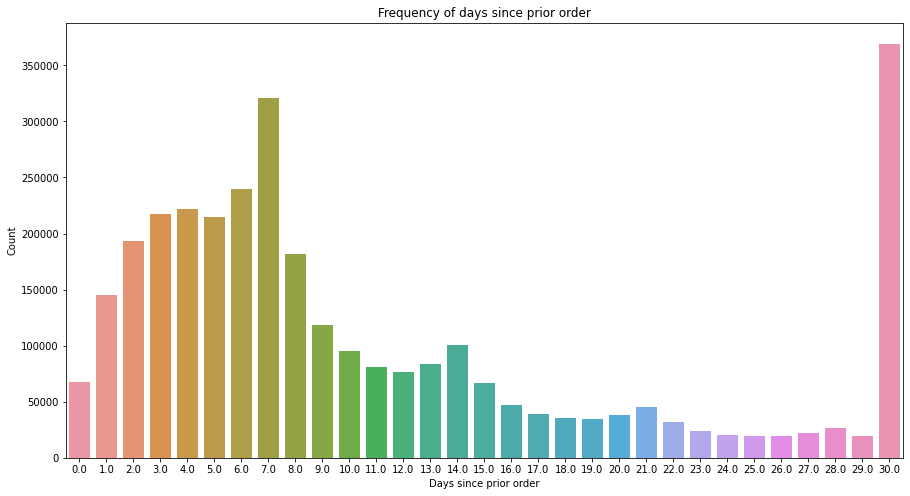

In [25]:
plt.figure(figsize = (15,8))
sns.countplot(x = 'days_since_prior_order', data = orders_df)
plt.ylabel('Count')
plt.xlabel('Days since prior order')
plt.title('Frequency of days since prior order')

Text(0.5, 1.0, 'Frequency of orders by hour of day')

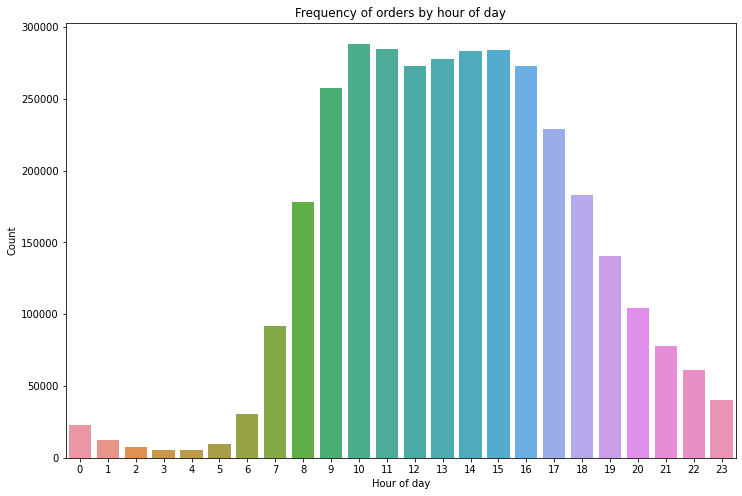

In [26]:
plt.figure(figsize = (12,8))
sns.countplot(x = "order_hour_of_day", data = orders_df)
plt.ylabel('Count')
plt.xlabel('Hour of day')
plt.title("Frequency of orders by hour of day")

Text(0.5, 1.0, 'Frequency of orders each day of the week')

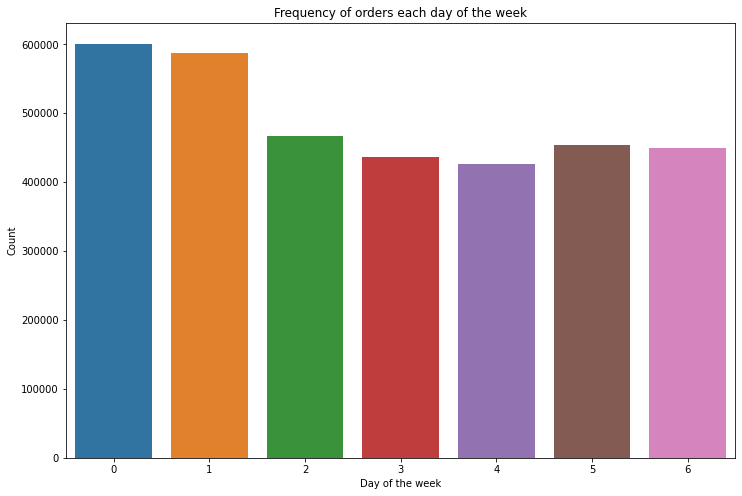

In [27]:
# Info learned: days of the week start from 0 and go to 6. Does not start on 1 like originally thought.
# Still unknown if 0 represents Sunday or Monday
# counts each individual order including orders from the training data as well as prior data.

plt.figure(figsize = (12,8))
sns.countplot(x = 'order_dow', data = orders_df)
plt.ylabel('Count')
plt.xlabel('Day of the week')
plt.title('Frequency of orders each day of the week')

<a id = "sec2"></a>
### Train-Test Splitting + Logistic Regression

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [29]:
#order_id_sorted_groups_sampled = order_id_sorted_groups.sample(n=2077, random_state=2020)
#order_id_sorted_groups_sampled

In [30]:
#order_id_sorted_groups_prep = order_id_sorted_groups.reset_index().dropna()
order_id_sorted_groups_prep = order_id_sorted_groups.reset_index().fillna(0)
order_id_sorted_groups_prep

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs,dairy eggs
1,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,205970,prior,16,5,17,12.0,yogurt,dairy eggs
2,4,46842,1,0,Plain Pre-Sliced Bagels,93,3,178520,prior,36,1,9,7.0,breakfast bakery,bakery
3,5,13176,1,1,Bag of Organic Bananas,24,4,156122,prior,42,6,16,9.0,fresh fruits,produce
4,6,40462,1,0,Cleanse,31,7,22352,prior,4,1,12,30.0,refrigerated,beverages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3214869,3421079,30136,1,0,Moisture Soap,25,11,108687,prior,6,1,13,0.0,soap,personal care
3214870,3421080,27845,1,1,Organic Whole Milk,84,16,52726,prior,2,1,11,2.0,milk,dairy eggs
3214871,3421081,38185,1,0,Hint of Lime Flavored Tortilla Chips,107,19,117076,prior,1,3,11,0.0,chips pretzels,snacks
3214872,3421082,17279,1,1,Fresh 99% Lean Ground Turkey,49,12,175185,prior,23,2,18,4.0,packaged poultry,meat seafood


In [31]:
# X = order_id_sorted_groups.drop('reordered', axis=1)
X = order_id_sorted_groups_prep[["order_dow", "days_since_prior_order", "order_hour_of_day"]]
y = order_id_sorted_groups_prep["reordered"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [32]:
X_train

,order_dow,days_since_prior_order,order_hour_of_day
2247950,6,30.0,23
843452,4,12.0,15
3123831,0,11.0,6
3018478,0,16.0,13
1728500,0,0.0,18
...,...,...,...
2322782,6,6.0,13
2952712,6,13.0,19
1995244,4,2.0,11
1634826,0,14.0,11


In [33]:
y_train

2247950    0
843452     1
3123831    1
3018478    0
1728500    0
          ..
2322782    1
2952712    1
1995244    1
1634826    1
639384     0
Name: reordered, Length: 2250411, dtype: int64

In [34]:
logmodel = LogisticRegression()
logmodel.fit(X_train, y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
predictions_LR = logmodel.predict(X_test)
report_LR = classification_report(y_test, predictions_LR)
cm_LR = confusion_matrix(y_test, predictions_LR)

print(report_LR)
print(cm_LR)

D:\Anaconda\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.



              precision    recall  f1-score   support

           0       0.00      0.00      0.00    310626
           1       0.68      1.00      0.81    653837

    accuracy                           0.68    964463
   macro avg       0.34      0.50      0.40    964463
weighted avg       0.46      0.68      0.55    964463

[[     0 310626]
 [     0 653837]]


Accuracy: 67.79%


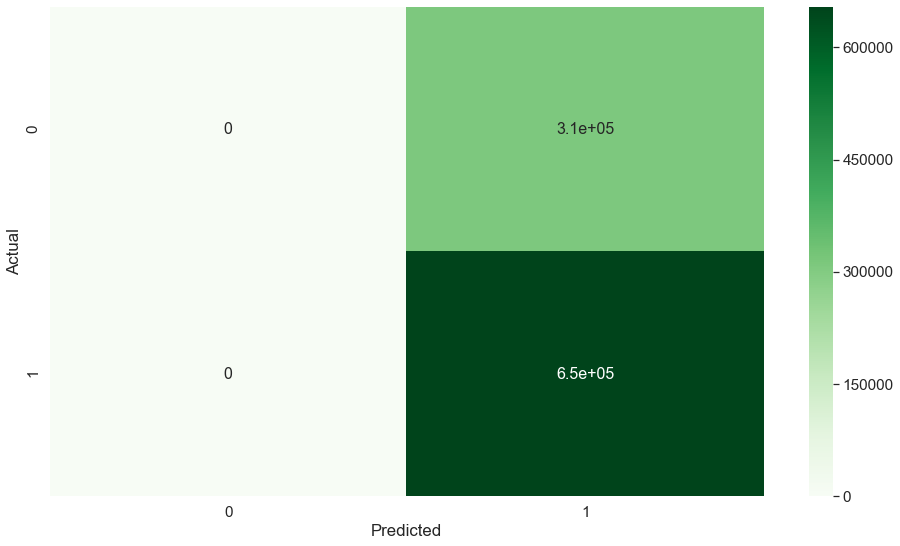

In [36]:
df_cm_LR = pd.DataFrame(cm_LR, columns=np.unique(y_test), index = np.unique(y_test))
df_cm_LR.index.name = 'Actual'
df_cm_LR.columns.name = 'Predicted'
plt.figure(figsize = (16,9))
sns.set(font_scale=1.4)#label size
sns.heatmap(df_cm_LR, cmap="Greens", annot=True,annot_kws={"size": 16})
# evaluate predictions
accuracy_LR = accuracy_score(y_test, predictions_LR)
print("Accuracy: %.2f%%" % (accuracy_LR * 100.0))

In [37]:
np.unique(y_test)

array([0, 1], dtype=int64)

https://miro.medium.com/max/809/1*7EYylA6XlXSGBCF77j_rOA.png

<a id = "sec3"></a>
## XGBoost tryout

### 1. Vanilla (without feature selection)

Reference: https://machinelearningmastery.com/develop-first-xgboost-model-python-scikit-learn/

In [38]:
# fit model with some training data, maybe???
modelXGB = XGBClassifier()
modelXGB.fit(X_train, y_train)
print(modelXGB)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [39]:
# make predictions for the test data
y_pred_XGB = modelXGB.predict(X_test)
predictions_XGB = [round(value) for value in y_pred_XGB]
# evaluate predictions
accuracy_XGB = accuracy_score(y_test, predictions_XGB)


report_XGB = classification_report(y_test, predictions_XGB)
cm_XGB = confusion_matrix(y_test, predictions_XGB)

print(report_XGB)
print(cm_XGB)

print("Accuracy: %.2f%%" % (accuracy_XGB * 100.0))

              precision    recall  f1-score   support

           0       0.83      0.22      0.34    310626
           1       0.72      0.98      0.83    653837

    accuracy                           0.73    964463
   macro avg       0.78      0.60      0.59    964463
weighted avg       0.76      0.73      0.67    964463

[[ 66911 243715]
 [ 13931 639906]]
Accuracy: 73.29%


Accuracy: 73.29%


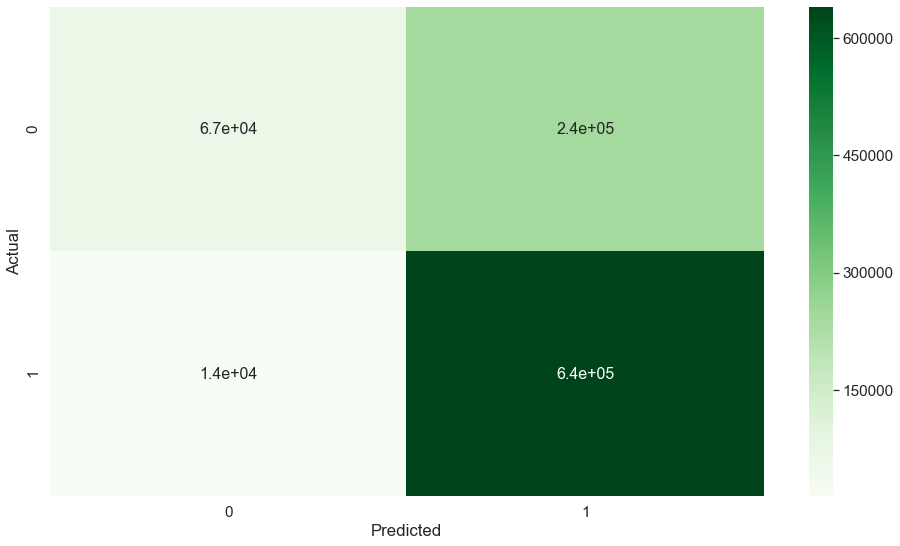

In [40]:
df_cm_XGB = pd.DataFrame(cm_XGB, columns=np.unique(y_test), index = np.unique(y_test))
df_cm_XGB.index.name = 'Actual'
df_cm_XGB.columns.name = 'Predicted'
plt.figure(figsize = (16,9))
sns.set(font_scale=1.4)#label size
sns.heatmap(df_cm_XGB, cmap="Greens", annot=True,annot_kws={"size": 16})
# evaluate predictions
accuracy_XGB = accuracy_score(y_test, predictions_XGB)
print("Accuracy: %.2f%%" % (accuracy_XGB * 100.0))

### 2. With Feature Selection

Reference: https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/

In [ ]:
## {WIP}